Implementing Beamformers
=========================

This Jupyter notebook will outline the step-by-step process of implementing a new receiving beamformer within the HermesPy framework, using the Minimum Variance Distortionless Response (MVDR, also known as <strict data-cite="1969:capon">Capon</strict>) beamformer as a working example.

As an initial step, we will import all required modules from HermesPy:

In [1]:
import numpy as np

from hermespy.beamforming import ReceiveBeamformer

The Capon beamformer estimates the power $\hat{P}$ received from a direction $(\theta, \phi)$, where $\theta$ is the zenith and $\phi$ is the azimuth angle of interest in spherical coordinates, respectively. 
Let $Y \in \mathbb{C}^{M \times N}$ be the the matrix of $N$ time-discrete samples acquired by an antenna arrary featuring $M$ antennas and

\begin{equation}
\mathbf{R} = \mathbf{Y}\mathbf{Y}^{\mathsf{H}}
\end{equation}

be the respective sample correlation matrix.
The antenna array's response towards a source within its far field emitting a signal of small relative bandwidth is $\mathbf{a}(\theta, \phi) \in \mathbb{C}^{M}$.
Then, the Capon's spatial power response is defined as 

\begin{equation}
\hat{P}_{\mathrm{Capon}}(\theta, \phi) = \frac{1}{\mathbf{a}^{\mathsf{H}}(\theta, \phi) \mathbf{R}^{-1} \mathbf{a}(\theta, \phi)}
\end{equation}

with

\begin{equation}
\mathbf{w}(\theta, \phi) = \frac{\mathbf{R}^{-1} \mathbf{a}(\theta, \phi)}{\mathbf{a}^{\mathsf{H}}(\theta, \phi) \mathbf{R}^{-1} \mathbf{a}(\theta, \phi)} \in \mathbb{C}^{M}
\end{equation}

being the beamforming weights to steer the sensor array's receive characteristics towards direction $(\theta, \phi)$, so that

\begin{equation}
\tilde{\mathbf{y}}(\theta, \phi) = \mathbf{w}^\mathsf{H}(\theta, \phi) \mathbf{Y}
\end{equation}

are the estimated signal samples impinging onto the sensor array from said direction.

The structure of receiving beamformers is implemented as an abstract prototype in the [ReceiveBeamformer](../api/beamforming.beamformer.rst#hermespy.beamforming.beamformer.ReceiveBeamformer).
Prototypes specify several [abstract](https://docs.python.org/3/library/abc.html#abc.abstractmethod) properties and methods which inheriting classes must implement. For receiving beamformers those are

* [num_receive_input_streams](../api/beamforming.beamformer.rst#hermespy.beamforming.beamformer.ReceiveBeamformer.num_receive_input_streams) - *Number of antenna streams the beamformer can process.*<br />Our Capon implementation will always require the samples of all device antennas.

* [num_receive_output_streams](../api/beamforming.beamformer.rst#hermespy.beamforming.beamformer.ReceiveBeamformer.num_receive_output_streams) - *Number of antenna streams the beamformer generates after processing.*<br />Since the Capon beamformer focuses the power towards a single direction of interest per estimation, a single stream of samples will be generated after beamforming.

* [num_receive_focus_angles](../api/beamforming.beamformer.rst#hermespy.beamforming.beamformer.ReceiveBeamformer.num_receive_focus_angles) - *Number of angles of interest the beamformer requires for its configuration.*<br />The same logic as before applies, only a single direction of interest per beamforming operation is required.

* [\_decode()](../api/beamforming.beamformer.rst#hermespy.beamforming.beamformer.ReceiveBeamformer._decode) - *This subroutine performs the actual beamforming, given an array of baseband samples, assumed carrier frequency and the angles of interest.* <br />
This is where the Capon algorithm is being implemented.

In [2]:
class CaponBeamformer(ReceiveBeamformer):
    
    def __init__(self, *args, **kwargs) -> None:
        
        ReceiveBeamformer.__init__(self, *args, **kwargs)

    @property
    def num_receive_input_streams(self) -> int:
        return self.operator.device.antennas.num_receive_antennas
    
    @property
    def num_receive_output_streams(self) -> int:
        return 1
        
    @property
    def num_receive_focus_angles(self) -> int:
        return 1
        
    def _decode(self,
                samples: np.ndarray,
                carrier_frequency: float,
                angles: np.ndarray) -> np.ndarray:
        
        # Compute the inverse sample covariance matrix R
        sample_covariance = np.linalg.inv(samples @ samples.T.conj() + np.eye(samples.shape[0]))

        # Query the sensor array response vectors for the angles of interest and create a dictionary from it
        dictionary = np.empty((self.num_receive_input_streams, angles.shape[0]), dtype=complex)
        for d, focus in enumerate(angles):
            array_response = self.operator.device.antennas.spherical_phase_response(carrier_frequency, focus[0, 0], focus[0, 1])
            dictionary[:, d] = sample_covariance @ array_response / (array_response.T.conj() @ sample_covariance @ array_response)

        beamformed_samples = dictionary.T.conj() @ samples
        return beamformed_samples[:, np.newaxis, :]

And that's it, by specifying three properties and the decode routine a new beamformer has been implemented within HermesPy.
We can now plot the beamforming characteristics towards a signal impinging from $(\theta = 0, \phi = 0)$ by calling [PlotReceivePattern()](../api/beamforming.beamformer.rst#hermespy.beamforming.beamformer.ReceiveBeamformer.PlotReceivePattern) and compare it to the [CoventionalBeamformer](../api/beamforming.conventional.rst#hermespy.beamforming.conventional.ConventionalBeamformer):

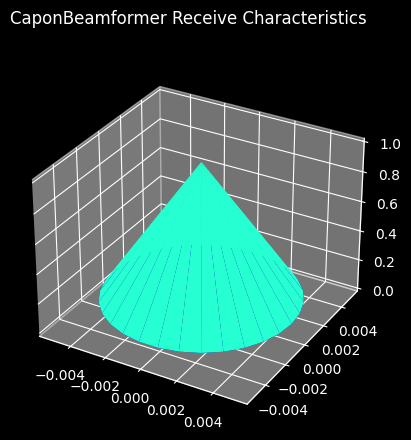

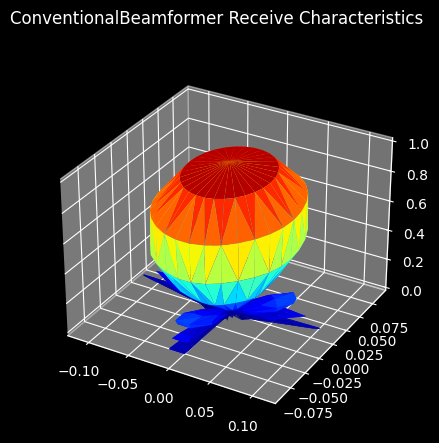

In [3]:
from hermespy.beamforming import ConventionalBeamformer

_ = CaponBeamformer.PlotReceivePattern()
_ = ConventionalBeamformer.PlotReceivePattern()

We may now use the newly created beamforming class to configure receive signal processing chains within HermesPy.
For example, within an imaging radar application simulation:

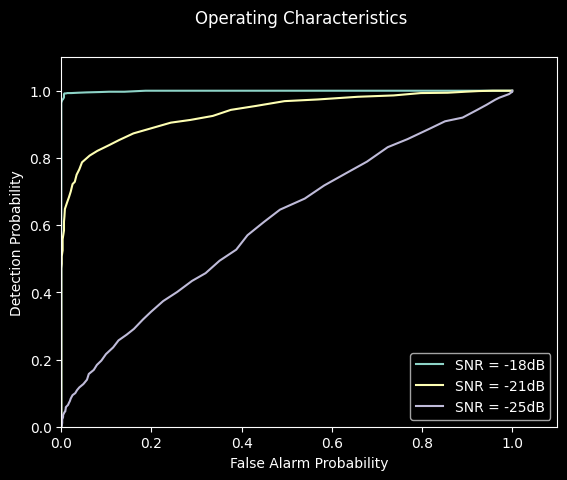

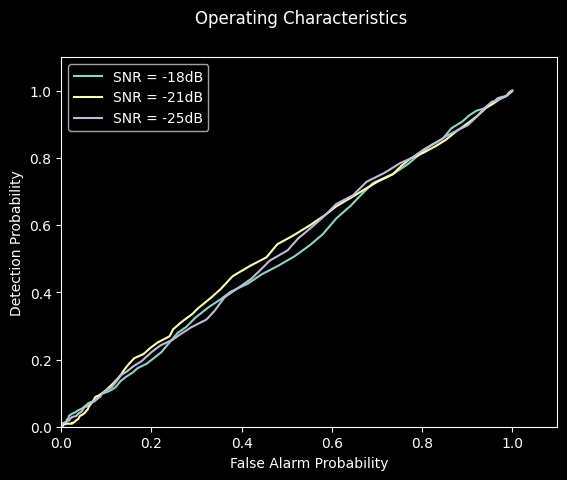

In [4]:
import numpy as np
from scipy.constants import pi, speed_of_light

from hermespy.core import dB, ConsoleMode, UniformArray, IdealAntenna
from hermespy.channel import SingleTargetRadarChannel
from hermespy.simulation import Simulation
from hermespy.radar import Radar, FMCW, ReceiverOperatingCharacteristic

# Create a new simulation featuring a single device transmitting at 10GHz
simulation = Simulation(console_mode=ConsoleMode.SILENT)
device = simulation.scenario.new_device(antennas=UniformArray(IdealAntenna(), .5 * speed_of_light / 10e9, (3, 3)))
device.carrier_frequency = 10e9

radar_channel = SingleTargetRadarChannel(target_range=10., radar_cross_section=1., attenuate=False)
simulation.scenario.set_channel(device, device, radar_channel)

# Configure a radar operation on the device
radar = Radar()
radar.device = device
radar.waveform = FMCW()
radar.receive_beamformer = ConventionalBeamformer()

simulation.add_evaluator(ReceiverOperatingCharacteristic(radar, radar_channel))
simulation.new_dimension('snr',  dB(-18, -21, -25))
simulation.num_samples = 1000

radar.receive_beamformer.probe_focus_points = np.array([[0., 0.]])
result = simulation.run()
_ = result.plot()

radar.receive_beamformer.probe_focus_points = np.array([[.5*pi, .5*pi]])
result = simulation.run()
_ = result.plot()